

```
The Notebook can be loaded from this link:
https://colab.research.google.com/drive/1hYfTuLktgXm-uD9N3fKXlxCAXQ7V4bYN
```



In [1]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/chengmar09/comp0053.git  

GitHub user········
GitHub password········


fatal: destination path 'comp0053' already exists and is not an empty directory.


In [17]:
!echo 'Check Current Dir'
%cd /content/comp0053/
%tensorflow_version 1.x
!pwd && ls
!pip install -r Requirement.txt
!pip install h5py

'Check Current Dir'
[WinError 3] The system cannot find the path specified: '/content/comp0053/'
C:\Users\mary\Desktop\comp0053\comp0053


UsageError: Line magic function `%tensorflow_version` not found.


In [23]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/34/d5/ce8c17971067c0184c9045112b755be5461d5ce5253ef65a367e1298d7c5/tensorflow-2.1.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [30]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
from helper import *
import scipy

movementDataLoader = DataReader('Movementdata') #<- Automatically download data
(train_x, train_y), (valid_x, valid_y) = movementDataLoader.more_more_processing(v_stack=False)

Using TensorFlow backend.


Create a ->Movementdata<- folder 

Now downloading training data
100% [........................................................................] 65112138 / 65112138
Now downloading Validation data
100% [........................................................................] 28195726 / 28195726Unzipping training data
Unzipping validation data
There is total of 23 training data
There is total of 12 Validation data


# Visualising the imbalance 

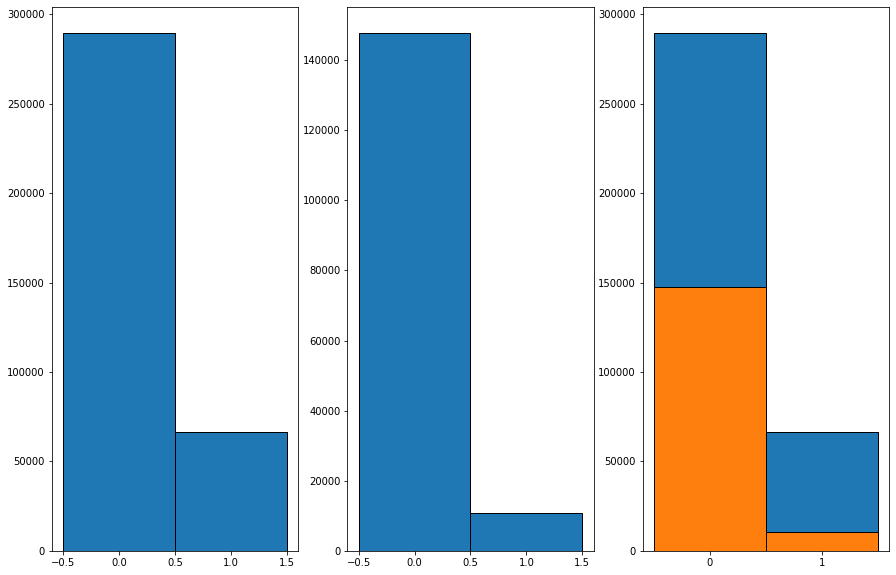

In [108]:
import matplotlib.pyplot as plt

def visualise_imbalance(train_y, valid_y ,labels=[0,1]):

    fig, axes= plt.subplots(nrows=1, ncols=3, figsize = (15,10))
    plt.xticks((0,1))
    axes[0].hist(train_y, label=labels, bins=[-.5,.5,1.5], ec="k")
    axes[1].hist(valid_y, label=labels, bins=[-.5,.5,1.5], ec="k")

    axes[2].hist(train_y, label=labels, bins=[-.5,.5,1.5], ec="k")
    axes[2].hist(valid_y, label=labels, bins=[-.5,.5,1.5], ec="k")

    plt.show()

visualise_imbalance(train_y,valid_y)

Class Imbalance

<br>
Looking at the histogram for Ground Truth, we can see that our dataset is heavily biased towards 0 class. From this we can conlude
that when choosing algorithms to apply to the dataset, we must be wary of choosing ones that are sensitve to class
imbalance, as they may be heavily biased towards the more prevalent class.
This fact also suggests that using a simple metric for evaluating the quality of a model, such as misclassification loss may produce a poor estimate for generalisation loss, as the algorithm may learn to simply always predict the more common class and still obtain high accuracy. <br>

<br>
Finally, given the imbalance of classes in the dataset, when constructing validation sets (or cross-validation folds) for validation if chosen poorly we have a high likelihood of obtaining subsets of only the non-default data, resulting in poor estimates for the true generalisation loss. Hence, this visualization suggests that it might be worthwhile investing in using
stratified techniques when splitting the data for validation.

2D Scatterplot of the imbalance


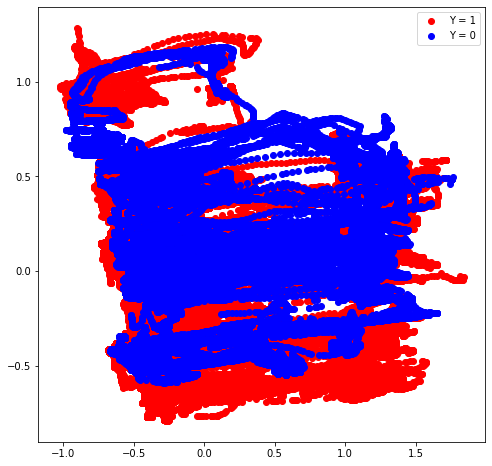

3D Scatterplot of the imbalance


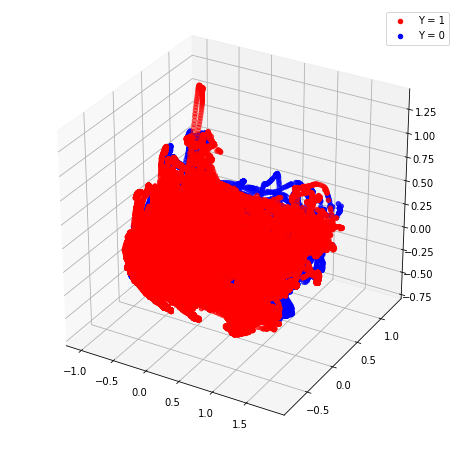

In [4]:
#Dimensionality Reduction imports
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
def transform_and_plot(model, data=train_x, labels=train_y):
    """
    Fits a given model over the scaled dataset and plots the result
    :param model - the untrained model to be fitted over the data
    :param data - the scaled data to be transformed
    :param labels - the corresponding labels for the data
    """

    reduced = model.fit_transform(data)
    dimensions = reduced.shape[1]
    print("{}D Scatterplot of the imbalance".format(dimensions))
    labelled = np.c_[reduced, labels]
    assert dimensions == 2 or dimensions == 3, 'transform only supports 2 or 3 dimensions'
    projection = None
    if dimensions == 3:
        projection = '3d'
    
    figure = plt.figure(figsize=(8,8))
    ax = figure.add_subplot(1,1,1, projection=projection)
    neg = reduced[labelled[:,dimensions] == 0]
    pos = reduced[labelled[:,dimensions] == 1]
    ax.scatter(*(neg[:,i] for i in range(dimensions)), c='r')
    ax.scatter(*(pos[:,i] for i in range(dimensions)), c='b')
    ax.legend(['Y = 1', 'Y = 0'])
    plt.show()
#     time.sleep(10)

transform_and_plot(PCA(n_components=2), train_x, train_y)
transform_and_plot(PCA(n_components=3), train_x, train_y)


# Splitting the training data into different modality

In [41]:
joint_angles = train_x [:,:12]
joint_energies = train_x[:,13:26]
print(original dimensions)
print("joint angles: {}, joint energies: {}, joint angles + joint energies: {}".format(joint_angles.shape, joint_energies.shape, train_x.shape)



SyntaxError: invalid syntax (<ipython-input-41-74c8d9376314>, line 3)

# Feature Selection using PCA

PCA reduces the dimensionality to only the n most important component (n_components = 0.99)

The first graph shows the number of components n we need to take to taken into account for 99% of variance and the scatter plot shows the clustering of the first 2 dimensions  

number of features selected: 10


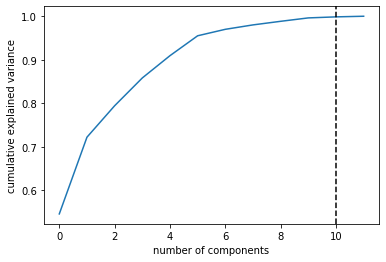

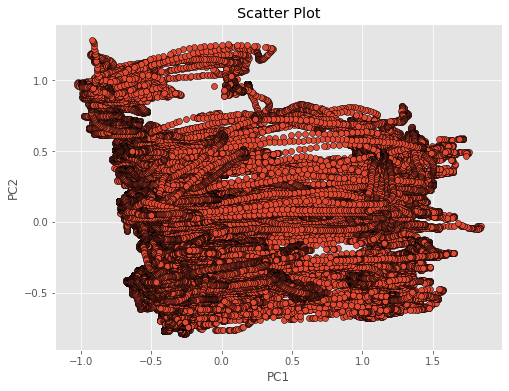

number of features selected: 10


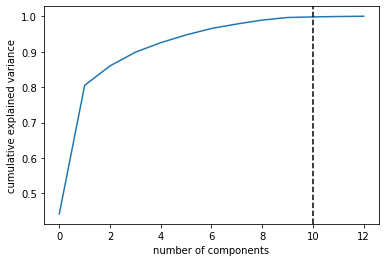

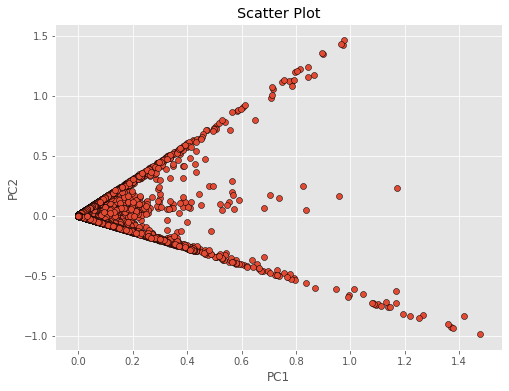

number of features selected: 11


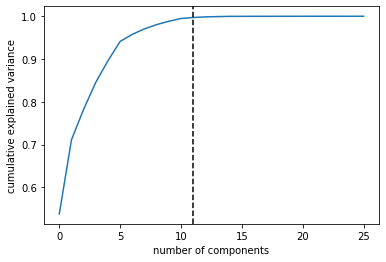

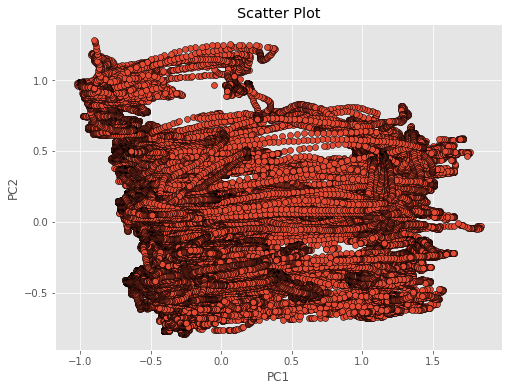

In [38]:
#Dimensionality Reduction imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import matplotlib.pyplot as plt

def plot_cumsum_pca (data):
    pca = PCA()
    data_pca = pca.fit(data)
    x_line= np.where(np.cumsum(pca.explained_variance_ratio_)>0.99)[0][1]
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.axvline(x=x_line, ls='--', c='k')
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    return x_line
    
def plot_pca(data,x_line):
    fig = plt.figure(figsize=(8,6))
    with plt.style.context(('ggplot')):
        plt.scatter(data[:,0], data[:,1], edgecolors='k', cmap='jet')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('Scatter Plot')
    plt.show()

def pca_selection(data):
    x_line= plot_cumsum_pca(data)
    pca = PCA(n_components=0.99)
    reduced = pca.fit_transform(data)
    print("number of features selected: {}".format(pca.n_components_))
    plot_pca(reduced, x_line)
    return pca.components_

for item in [joint_angles, joint_energies, train_x]:
    pca_selection(item)


# Feature Selection using Lasso

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

def lasso_selection(X, y= train_y):
    y = np.ravel(y)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"))
    embeded_lr_selector.fit(X, y)
    embeded_lr_support = embeded_lr_selector.get_support()
#     print(embeded_lr_support)
    embeded_lr_feature = embeded_lr_selector.transform(X)
#     print(embeded_lr_feature)
    print('selected features {}'.format(embeded_lr_feature.shape))
    return embeded_lr_feature

for item in [joint_angles, joint_energies, train_x]:
    lasso_selection(item, train_y)

selected features (356107, 12)
selected features (356107, 10)
selected features (356107, 22)


# Feature Selection using Random Forest Classifier

random forest has an in-built functionality of choosing the features with highest feature importance score
the value of the n_estimators should be tested

In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


def tree_selection(X, y, estimator):
    y = np.ravel(y)
    #try 10,30,100
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=estimator))
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
#     print(embeded_rf_support)
    embeded_rf_feature = embeded_rf_selector.transform(X)
#     print(embeded_rf_feature)
    print('selected features {}'.format(embeded_rf_feature.shape))
    return embeded_rf_feature

for item in [joint_angles, joint_energies, train_x]:
    for estimator in [10,30,100]:
        tree_selection(item, train_y, estimator)

selected features (356107, 6)
selected features (356107, 6)
selected features (356107, 5)
selected features (356107, 8)
selected features (356107, 8)
selected features (356107, 8)
selected features (356107, 13)
selected features (356107, 13)
selected features (356107, 13)


# Feature Selection via Anova


<br>
Statistical tests can be used to select those features that have the strongest relationship with the output variable. The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features. <br>

<br>
Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data. This can be used via the f_classif() function. We will select the 4 best features using this method in the example below.

In [37]:
# load data
(train_x, train_y), _ = movementDataLoader.more_more_processing(v_stack=False)

# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova(X, y, k):
    # feature extraction
    test = SelectKBest(score_func=f_classif, k=k)
    fit = test.fit(X, Y)
    # summarize scores
    set_printoptions(precision=3)
    print('Fitting scores : {} \n length: {}'.format(fit.scores_, len(fit.scores_)))
    features = fit.transform(X)
    # summarize selected features
    print(features.shape)
    return features

X = train_x
Y = train_y.squeeze()
anova(X,Y,10)

Fitting scores : [ 526.428 2487.446   35.201  474.808  198.65   250.842  235.885 1028.863
  234.537 1938.149 4700.717 7024.874   58.877  725.637  514.023 1196.037
 1324.352 1065.226  695.219   39.522  209.71    46.532   20.442  754.793
  357.116   35.197] 
 length: 26
(356107, 10)


array([[8.018e-01, 3.096e-01, 1.001e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.017e-01, 3.097e-01, 1.000e+00, ..., 3.542e-10, 0.000e+00,
        5.741e-08],
       [8.016e-01, 3.097e-01, 9.996e-01, ..., 0.000e+00, 9.488e-10,
        4.653e-08],
       ...,
       [1.093e+00, 9.196e-01, 1.150e+00, ..., 3.851e-05, 2.999e-03,
        1.624e-05],
       [1.094e+00, 9.170e-01, 1.149e+00, ..., 1.657e-06, 4.449e-03,
        8.297e-06],
       [1.094e+00, 9.160e-01, 1.149e+00, ..., 7.365e-08, 2.757e-03,
        1.078e-05]])